SaliStruct Evaluation Analysis
--------------------------

This notebook documents the evaluation of predicted usability scores for mobile UI screenshots using saliency-based metrics. The predictions are compared against the ground truth `usability_rating` from the UICrit dataset.

Approach:
- Generate saliency maps (e.g., using Grad-CAM or other models)
- Compute visual attention and structure metrics
- Combine them into a composite usability score
- Evaluate predicted scores against human ratings

Dataset:
- [UICrit](https://github.com/google-research-datasets/uicrit) based on the RICO dataset
- Multiple usability ratings per screenshot per task
- We average ratings to one usability score per `rico_id`

Formulas:
- `UsabilityScore = f(entropy, clusters, COG, symmetry, coverage, placement)`
- Grad-CAM used as one of the saliency models

Note:
- Predicted scores range from 0–1
- Actual `usability_rating` ranges from 1–10
- We'll scale predicted scores ×10 for meaningful comparison

Total samples: 1000


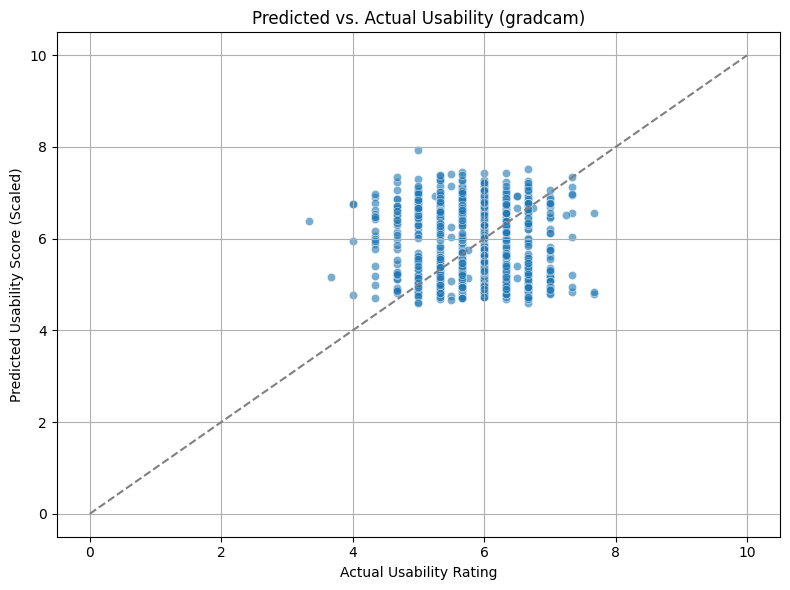


📈 Pearson correlation: -0.069
🔁 Spearman correlation: -0.063


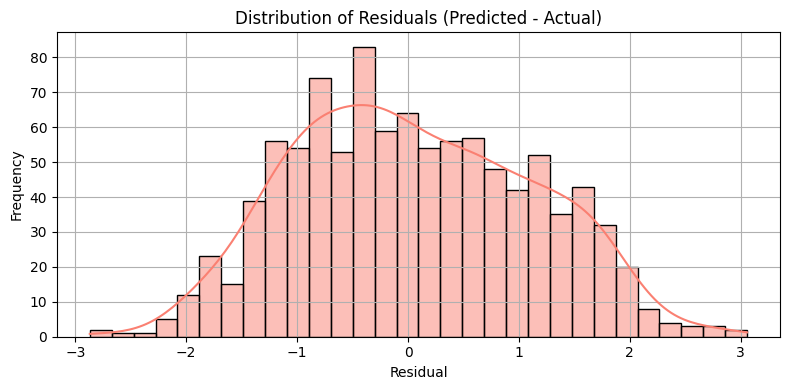

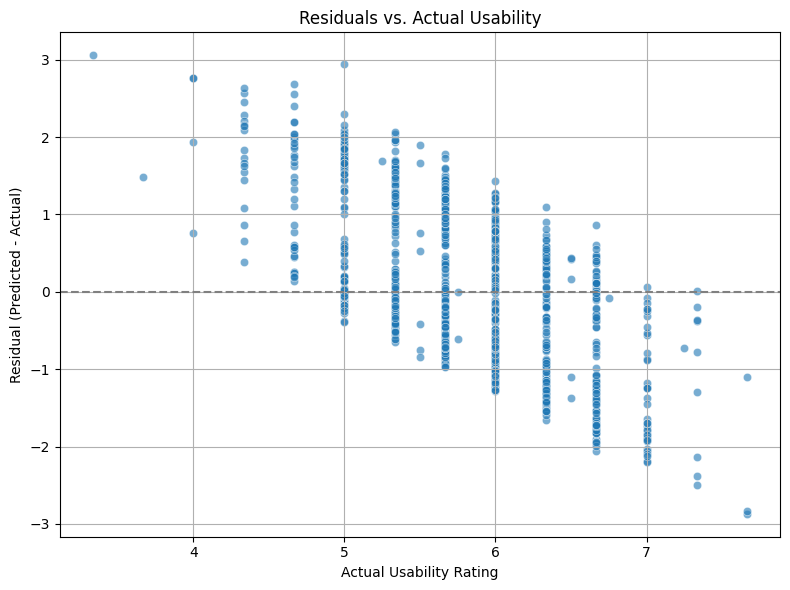

🔎 Top 10 Outliers
      filename  usability_rating  predicted_score  abs_error
427  30809.jpg          3.333333           6.3910   3.057667
780  56085.jpg          5.000000           7.9444   2.944400
332  24203.jpg          7.666667           4.7971   2.869567
510  36768.jpg          7.666667           4.8295   2.837167
238  16155.jpg          4.000000           6.7609   2.760900
807  57929.jpg          4.000000           6.7591   2.759100
490  35542.jpg          4.666667           7.3504   2.683733
360  26551.jpg          4.333333           6.9724   2.639067
84    5897.jpg          4.333333           6.9085   2.575167
243  16595.jpg          4.666667           7.2280   2.561333


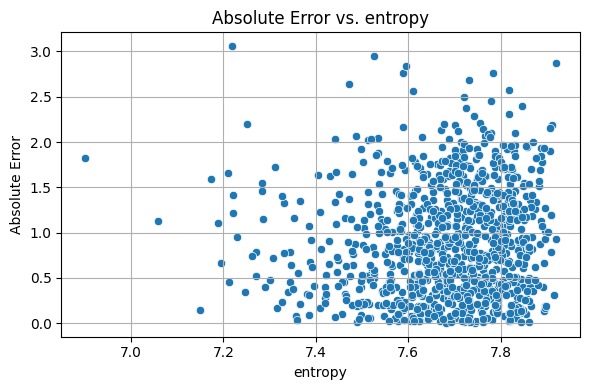

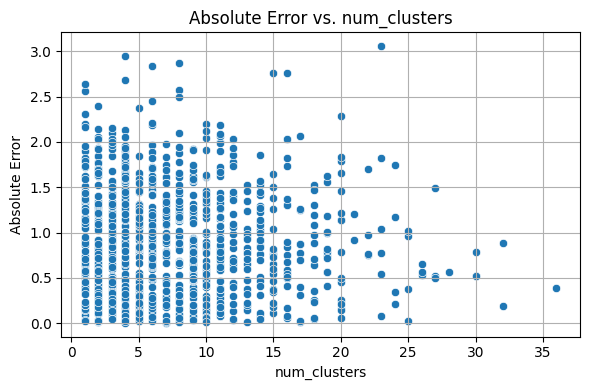

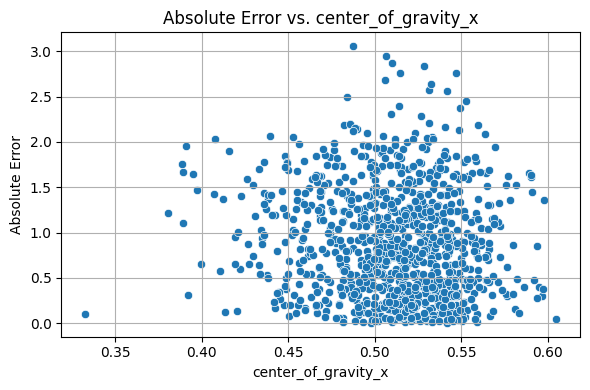

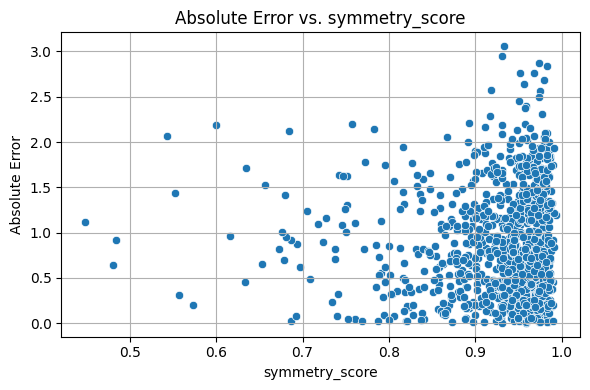

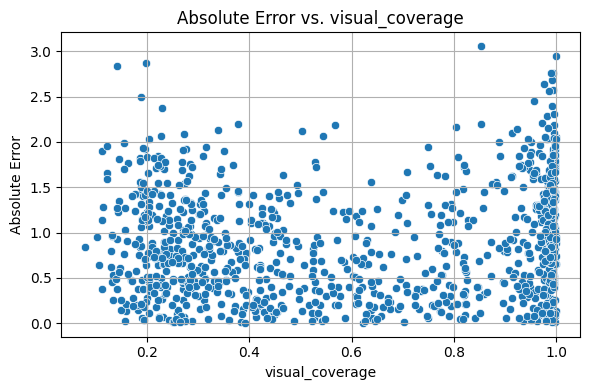

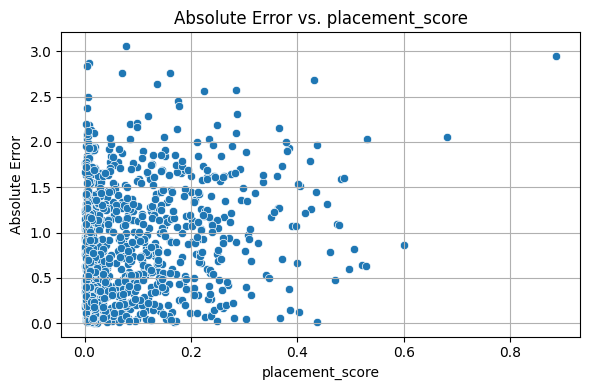

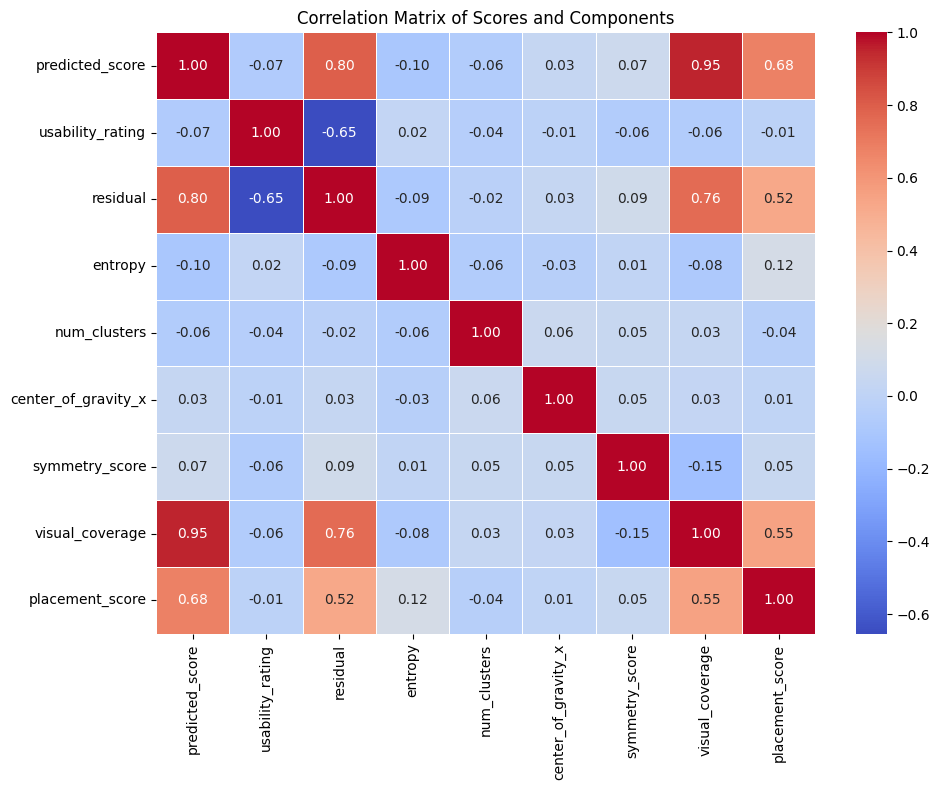

In [13]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

# Load evaluation results
saliency_model = 'gradcam'
df = pd.read_csv(f'../eval/uicrit_eval_results_{saliency_model}.csv')

# Overview
print(f"Total samples: {len(df)}")
df[['usability_rating', 'predicted_score']].describe()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x='usability_rating', y='predicted_score', data=df, alpha=0.6)
plt.plot([0, 10], [0, 10], '--', color='gray')
plt.xlabel("Actual Usability Rating")
plt.ylabel("Predicted Usability Score (Scaled)")
plt.title(f"Predicted vs. Actual Usability ({saliency_model})")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation analysis
pearson_corr, _ = pearsonr(df["usability_rating"], df["predicted_score"])
spearman_corr, _ = spearmanr(df["usability_rating"], df["predicted_score"])

print(f"\n📈 Pearson correlation: {pearson_corr:.3f}")
print(f"🔁 Spearman correlation: {spearman_corr:.3f}")

# Residuals and error metrics
df['residual'] = df['predicted_score'] - df['usability_rating']
df['abs_error'] = df['residual'].abs()

# Residual distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['residual'], bins=30, kde=True, color='salmon')
plt.title("Distribution of Residuals (Predicted - Actual)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x='usability_rating', y='residual', data=df, alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Actual Usability Rating")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residuals vs. Actual Usability")
plt.grid(True)
plt.tight_layout()
plt.show()

# Top 5 outliers
outliers = df.sort_values('abs_error', ascending=False).head(10)
print("🔎 Top 10 Outliers")
print(outliers[['filename', 'usability_rating', 'predicted_score', 'abs_error']])

# Error breakdown by score components
component_cols = [
    'entropy', 'num_clusters', 'center_of_gravity_x',
    'symmetry_score', 'visual_coverage', 'placement_score'
]

for col in component_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['abs_error'])
    plt.title(f"Absolute Error vs. {col}")
    plt.xlabel(col)
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Correlation matrix for all metrics
plt.figure(figsize=(10, 8))
corr_matrix = df[['predicted_score', 'usability_rating', 'residual'] + component_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Scores and Components")
plt.tight_layout()
plt.show()


Next steps:
- Compare different saliency models (e.g., SAM, traditional)
- Analyze error distribution
- Visualize score components
- Publish insights in paper/report